Лабораторная работа №10 “Градиентный бустинг”
=====
Лабораточная работа выполнена на языке **Python** c помощью интерактивной оболочки **Jupyter Notebook**.
Исходный код работы - lab9.py.
Файл jupyter notebook - lab9.ipynb.

Для выполнения задания используется набор данных boston из библиотеки sklearn.

## Ход работы

#### Загружаем данные данные с помощью библиотеки sklearn

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import sklearn.datasets
import sklearn.model_selection
from sklearn.tree import DecisionTreeRegressor

In [8]:
boston = sklearn.datasets.load_boston()

#### Разделим выборку на обучающую (75%) и контрольную (25%).

In [9]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    boston.data.astype(np.float32), 
    boston.target, 
    test_size=0.25, 
    random_state=42
)

#### В цикле обучитим последовательно 50 решающих деревьев с параметрами max_depth=5 и random_state=42 (остальные параметры - по умолчанию). Используем коэффициент 0.9 для каждого отдельного дерева.

In [23]:
def train_boosted(X, y,
                  num_iters=50,
                  get_weight=lambda x: 0.9 / (1.0 + x),
                  get_clf=lambda: DecisionTreeRegressor(max_depth=5, random_state=42)):

    models = []
    y = np.copy(y)
    weights = np.ones(shape=(num_iters,))
    for i in range(num_iters):
        clf = get_clf()
        clf.fit(X_train, y)
        models.append(clf)
        wi = get_weight(i)
        weights[i] = wi
        pred, loss = predict_boosted(models, X_train, y_train, weights)
        h = clf.predict(X_train)
        y = y - h * weights[i]

    return models, weights

#### Функция, которая вычисляет прогноз на уже построенных деревьях и оценивает качество работы алгоритма с помощью mean_squared_error в sklearn.metrics

In [24]:
def predict_boosted(models, X, y, weights):
    p = np.zeros(y.shape)
    for i, model in enumerate(models):
        p += model.predict(X) * weights[i]

    loss = sklearn.metrics.mean_squared_error(y, p)
    return p, loss

#### Проверим работу алгоритма

In [25]:
models, weights = train_boosted(X_train, y_train, num_iters=50,
                                get_weight=lambda x: 0.9)

p, loss = predict_boosted(models, X_train, y_train, weights)
print(f'Achieved on training set MSE loss: {loss:.6}')
p_val, val_loss = predict_boosted(models, X_test, y_test, weights)
print(f'Achieved on validation set MSE loss: {val_loss:.6}')

Achieved on training set MSE loss: 3.76862e-05
Achieved on validation set MSE loss: 13.6007


#### Попробуем уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49)

In [26]:
models, weights = train_boosted(X_train, y_train, num_iters=50)

p, loss = predict_boosted(models, X_train, y_train, weights)
print(f'Achieved on training set MSE loss: {loss:.6}')
p_val, val_loss = predict_boosted(models, X_test, y_test, weights)
print(f'Achieved on validation set MSE loss: {val_loss:.6}')

Achieved on training set MSE loss: 1.42114
Achieved on validation set MSE loss: 8.98735


По результатам обучения двух моделей, одна с коэффициентом 0.9, вторая с адаптивным коэффициентом, видно что для коэффицинта 0.9 модель намного лучше обучается на тренировочной выборке, но хуже себя показывает на валидационной выборке. 

#### Проверим переобучается ли градиентный бустинг с ростом числа итераций.

In [27]:
def cross_validate_num_iters(X_train, y_train, X_val, y_val):
    steps = 10
    iters = np.linspace(5, 200, steps, dtype=int)
    training_loss = np.zeros(steps)
    validation_loss = np.zeros(steps)
    for i, num_iters in enumerate(iters):
        models, weights = train_boosted(X_train, y_train, num_iters)
        p, loss = predict_boosted(models, X_train, y_train, weights)
        p_val, val_loss = predict_boosted(models, X_val, y_val, weights)
        training_loss[i] = loss
        validation_loss[i] = val_loss

    best_iters = iters[validation_loss.argmin()]
    return best_iters, training_loss, validation_loss, iters

In [39]:
num_iters, training_loss, validation_loss, iters = cross_validate_num_iters(X_train, y_train, X_test, y_test)

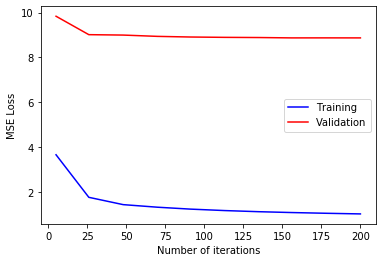

In [40]:
plt.figure()
plt.plot(iters, training_loss, c='b')
plt.plot(iters, validation_loss, c='r')
plt.xlabel('Number of iterations')
plt.ylabel('MSE Loss')
plt.legend(['Training', 'Validation'])
plt.show()

Используя адаптивный шаг для каждого последуещего дерева и кол-во итераций от 5 до 200 по графику видим, что функция потерь убывает для тренировочного набора, так и для валидационного. Т.е. переобчить модель не получилось.

#### Проверим переобучается ли градиентный бустинг с ростом глубины деревьев.

In [31]:
def cross_validate_tree_depth(X_train, y_train, X_val, y_val):
    depths = range(2, 20)
    steps = len(depths)
    training_loss = np.zeros(steps)
    validation_loss = np.zeros(steps)
    for i, depth in enumerate(depths):
        models, weights = train_boosted(X_train, y_train, get_clf=lambda: DecisionTreeRegressor(max_depth=depth, random_state=42))
        p, loss = predict_boosted(models, X_train, y_train, weights)
        p_val, val_loss = predict_boosted(models, X_val, y_val, weights)
        training_loss[i] = loss
        validation_loss[i] = val_loss

    best_depth = depths[validation_loss.argmin()]
    return best_depth, training_loss, validation_loss, depths

In [41]:
depth, training_loss, validation_loss, depths = cross_validate_tree_depth(X_train, y_train, X_test, y_test)
print(f'Found best tree depth = {depth} with MSE loss: {validation_loss.min():.6}')

Found best tree depth = 5 with MSE loss: 8.98735


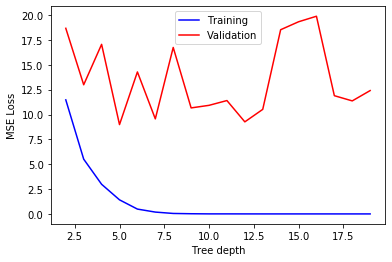

In [42]:
plt.figure()
plt.plot(depths, training_loss, c='b')
plt.plot(depths, validation_loss, c='r')
plt.xlabel('Tree depth')
plt.ylabel('MSE Loss')
plt.legend(['Training', 'Validation'])
plt.show()

Используя адаптивный шаг для каждого последуещего дерева, кол-во итераций от 50 и глубину деревьев от 2 до 20 по графику видим, что функция потерь для валидационной выборки ведет себя не стабильно в зависимости от грубины дереве, так или иначе в целом она возрастает после 5, а функция потерь на тренировочной выборке всегда убывает, что говорит о переобучении нашей модели.

#### Сравним качество, получаемое с помощью градиентного бустинга с качеством работы линейной регрессии.

In [44]:
import sklearn.linear_model

lr = sklearn.linear_model.LinearRegression()
lr.fit(X_train, y_train)
lrp = lr.predict(X_train)
lrp_val = lr.predict(X_test)
lr_loss_train = sklearn.metrics.mean_squared_error(y_train, lrp)
lr_loss_val = sklearn.metrics.mean_squared_error(y_test, lrp_val)
print(f'Linear regression model train MSE: {lr_loss_train:.6}')
print(f'Linear regression model validation MSE: {lr_loss_val:.6}')
print(f'Gradient boosting RMSE loss: {np.sqrt(val_loss):.6}\nLinear regression RMSE loss: {np.sqrt(lr_loss_val):.6}')
print(f'Gradient perfomance is {np.sqrt(lr_loss_val)/np.sqrt(val_loss):.2}X better')

Linear regression model train MSE: 22.3401
Linear regression model validation MSE: 22.0987
Gradient boosting RMSE loss: 2.99789
Linear regression RMSE loss: 4.70093
Gradient perfomance is 1.6X better


## Вывод
В данной работе была построенна модель градиентного бустинга используя деревья решений как целевую модель для бустинга, проверили как параметры модели влияют на результаты работы. Сравнили результаты работы модели градиентного бустинга с моделью линейной регресии.